<a href="https://colab.research.google.com/github/michaeltayou/Leaflet.MovingMarker/blob/master/lab7_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC-52081-EP Lab7: Optimization - CEM / ES

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/refs/heads/main/assets/logo.jpg" style="float: left; width: 15%" />

[CSC-52081-EP-2025](https://moodle.polytechnique.fr/course/view.php?id=19336) Lab session #7

2019-2025 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab7_optim.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main?filepath=lab7_optim.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab7_optim.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/raw/main/lab7_optim.ipynb)

## Introduction

In the previous lab we studied a method that allowed us to apply reinforcement learning in continuous state spaces and/or continuous action spaces.
We used REINFORCE, a *Policy gradient* method that directly optimize the parametric policy $\pi_{\theta}$.
The parameter $\theta$ was iteratively updated toward a local maximum of the total expected reward $J(\theta)$ using a gradient ascent method:
$$\theta \leftarrow \theta + \alpha \nabla_{\theta}J(\theta)$$
A convenient analytical formulation of $\nabla_{\theta}J(\theta)$ was obtained thanks to the *Policy Gradient theorem*:

$$\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (a|s) Q^{\pi_\theta}(s,a) \right].$$
However, gradient ascent methods may have a slow convergence and will only found a local optimum.
Moreover, this approach requires an analytical formulation of $\nabla_\theta \log \pi_\theta (s,a)$ which is not always known (when something else than a neural networks is used for the agent's policy).

Direct Policy Search methods using gradient free optimization procedures like Evolution Strategies or Cross Entropy Method (CEM) are interesting alternatives to Policy Gradient algorithms.
They can be successfully applied as long as the $\pi_\theta$ policy has no more than few hundreds of parameters.
Moreover, these method can solve complex problems that cannot be modeled as Markov Decision Processes.

As for previous Reinforcement Learning labs, we will use standard problems provided by Gymnasium suite.
Especially, we will try to solve the LunarLander-v3 problem (https://gymnasium.farama.org/environments/box2d/lunar_lander/) which offers both continuous states and action spaces.

As for previous labs, you can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab7_optim.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main?filepath=lab7_optim.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/raw/main/lab7_optim.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Lab Submission

Please submit your completed notebook in [Moodle : "Lab 7 - Submission"](https://moodle.polytechnique.fr/course/section.php?id=66535).

### Submission Guidelines

1. **File Naming:** Rename your notebook as follows: **`firstname_lastname-07.ipynb`** where `firstname` and `lastname` match your email address. *Example: `jesse_read-07.ipynb`*
2. **Clear Output Cells:** To reduce file size (**must be under 500 KB**), clear all output cells before submitting. This includes rendered images, videos, plots, and dataframes...
   - **JupyterLab:**
     - Click **"Kernel" → "Restart Kernel and Clear Outputs of All Cells..."**
     - Then go to **"File" → "Save Notebook As..."**
   - **Google Colab:**
     - Click **"Edit" → "Clear all outputs"**
     - Then go to **"File" → "Download" → "Download.ipynb"**
   - **VSCode:**
     - Click **"Clear All Outputs"**
     - Then **save your file**
3. **Upload Your File:** Only **`.ipynb`** files are accepted.

**Note:** Bonus parts (if any) are optional, as their name suggests.


## Setup the Python environment

This notebook relies on several libraries including `cma`, `gymnasium[box2d,classic-control]` (v1.0.0), `ipywidgets`, `matplotlib`, `moviepy`, `numpy`, `pandas`, `pygame`, `seaborn`, and `tqdm`.
A complete list of dependencies can be found in the following [requirements-lab7.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/requirements-lab7.txt) file.

### If you use Google Colab

If you use Google Colab, execute the next cell to install required libraries.

In [118]:
import sys
import subprocess


def is_colab() -> bool:
    return "google.colab" in sys.modules


def run_subprocess_command(cmd: str) -> None:
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())


if is_colab():
    run_subprocess_command("apt install swig")
    run_subprocess_command("pip install -r https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/requirements-lab7-google-colab.txt")

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


### If you have downloaded the notebook on your computer and execute it in your own Python environment

To set up the necessary dependencies, run the following commands to establish a [Python virtual environment (venv)](https://docs.python.org/3/library/venv.html) that includes all the essential libraries for this lab.

#### On Posix systems (Linux, MacOSX, WSL, ...)

```bash
python3 -m venv env-lab7
source env-lab7/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/requirements-lab7.txt
```

#### On Windows

```bash
python3 -m venv env-lab7
env-lab7\Scripts\activate.bat
python3 -m pip install --upgrade pip
python3 -m pip install -r https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/requirements-lab7.txt
```

### Run CSC-52081-EP notebooks locally in a dedicated Docker container

If you are familiar with Docker, an image is available on Docker Hub for this lab:

```bash
docker run -it --rm --user root -p 8888:8888 -e NB_UID=$(id -u) -e NB_GID=$(id -g) -v "${PWD}":/home/jovyan/work jdhp/csc-52081-ep:latest
```

### Import required packages

In [119]:
import gymnasium as gym
import math
import numpy as np
import pandas as pd
from pathlib import Path
import itertools
import torch
from typing import cast, List, Tuple, Deque, Optional, Callable

In [120]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [121]:
from IPython.display import Video
from ipywidgets import interact

In [122]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [123]:
sns.set_context("talk")

In [124]:
FIGS_DIR = Path("figs/") / "lab7"       # Where to save figures (.gif or .mp4 files)
PLOTS_DIR = Path("figs/") / "lab7"      # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/") / "lab7"   # Where to save models (.pth files)

In [125]:
if not FIGS_DIR.exists():
    FIGS_DIR.mkdir(parents=True)
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True)

## Define the video selector widget

The `video_selector` function, defined in the next cell, will be used in exercises 2, 3, 4 and 5 to display different episodes of the trained agent.

In [126]:
def video_selector(file_path: List[Path]) -> Video:
    return Video(file_path, embed=True, html_attributes="controls autoplay loop")

## PyTorch Refresher and Cheat Sheet

In this lab, we will be implementing our deep reinforcement learning algorithms using PyTorch.
If you need a refresher, you might find this [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html) helpful. It provides a quick reference for many of the most commonly used PyTorch functions and concepts, and can be a valuable resource as you work through this lab.

You can also refer to the [official documentation](https://pytorch.org/docs/stable/index.html).

## PyTorch setup

GPUs are useless for this lab. The following cell ask PyTorch to work on CPU.

In [127]:
device = "cpu"

## Exercise 1: Implement CEM and test it on the CartPole environment

Before solving the Lunar Lander environment, we will practice on the (simpler) CartPole environment.

**Reminder**: a description of the CartPole environment is available at https://gymnasium.farama.org/environments/classic_control/cart_pole/. This environment offers a continuous state space and discrete action space.

### Implement the policy to optimize

An implementation of the CartPole policy is given in the following cell.

In [128]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid function for the input array.

    Parameters
    ----------
    x : np.ndarray
        The input array for which to compute the sigmoid function.

    Returns
    -------
    np.ndarray
        The output array with the sigmoid function applied element-wise.
    """
    return 1.0 / (1.0 + np.exp(-x))


# Logistic Regression ############################################


class LogisticRegression:
    """
    Logistic Regression model for binary classification.

    Parameters
    ----------
    observations_size : int
        The size of the observation space.

    Attributes
    ----------
    observation_size : int
        The size of the observation space.
    params : np.ndarray
        The parameters of the logistic regression model.
    """

    def __init__(self, observations_size: int):
        """
        Initialize the LogisticRegression model with random parameters.

        Parameters
        ----------
        observations_size : int
            The size of the observation space.
        """
        self.observation_size = observations_size
        self.params = np.random.rand(observations_size)

    def __call__(self, observation: np.ndarray) -> int:
        """
        Predict the class label for a given observation.

        Parameters
        ----------
        observation : np.ndarray
            The input observation.

        Returns
        -------
        int
            The predicted class label (0 or 1).
        """
        prob_push_right = sigmoid(np.dot(observation, np.transpose(self.params)))
        return 1 if np.random.rand() < prob_push_right else 0

    def get_params(self) -> np.ndarray:
        """
        Get the parameters of the logistic regression model.

        Returns
        -------
        np.ndarray
            The parameters of the logistic regression model.
        """
        return self.params.copy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters of the logistic regression model.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the logistic regression model.
        """
        self.params = params.copy()

### Test the untrained agent

In [129]:
def test_agent(
    env: gym.Env, policy: torch.nn.Module, num_episode: int = 1
) -> List[float]:
    """
    Test a naive agent in the given environment using the provided Q-network.

    Parameters
    ----------
    env : gym.Env
        The environment in which to test the agent.
    policy : torch.nn.Module
        The neural network to use for decision making.
    num_episode : int, optional
        The number of episodes to run, by default 1.

    Returns
    -------
    List[float]
        A list of rewards per episode.
    """
    episode_reward_list = []

    for episode_id in range(num_episode):
        observation, info = env.reset()
        done = False
        episode_reward = 0.0

        while not done:

            # action = ... # TODO...
            action = policy(observation)

            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += float(reward)

            observation = next_observation

        episode_reward_list.append(episode_reward)
        print(f"Episode reward: {episode_reward}")

    return episode_reward_list

In [130]:
VIDEO_PREFIX_EX1_UNTRAINED = "lab7_ex1_untained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX1_UNTRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX1_UNTRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

nn_policy = LogisticRegression(env.observation_space.shape[0])

test_agent(env, nn_policy, num_episode=NUM_EPISODES)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);

Episode reward: 31.0
Episode reward: 13.0
Episode reward: 17.0

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex1_untained-episod…

### Implement the objective function

Optimization algorithms aim to find the minimum of a function. This function is called an "objective function".
The cell below implements the framework for such a function.
Note that in reinforcement learning, by convention the score is a reward to maximize whereas in mathematical optimization the score is a cost to minimize (most optimization libraries like PyCMA used in this lab impose this convention) ; the objective function will therefore return the opposite of the reward as the score of evaluated policies.

In [131]:
class ObjectiveFunction:
    """
    Objective function for evaluating a policy in a given environment.

    Parameters
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    num_episodes : int, optional
        The number of episodes to run for each evaluation, by default 1.
    max_time_steps : float, optional
        The maximum number of time steps per episode, by default float("inf").
    minimization_solver : bool, optional
        Whether the solver is a minimization solver, by default True.

    Attributes
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    num_episodes : int
        The number of episodes to run for each evaluation.
    max_time_steps : float
        The maximum number of time steps per episode.
    minimization_solver : bool
        Whether the solver is a minimization solver.
    num_evals : int
        The number of evaluations performed.
    """

    def __init__(
        self,
        env: gym.Env,
        policy: torch.nn.Module,
        num_episodes: int = 1,
        max_time_steps: float = float("inf"),
        minimization_solver: bool = True,
    ):
        self.env = env
        self.policy = policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0

    def eval(self, policy_params: np.ndarray, num_episodes: Optional[int] = None, max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        self.policy.set_params(policy_params)

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):
            total_rewards = 0.0
            observation, info = self.env.reset()

            for t in range(max_time_steps):
                action = self.policy(observation)
                observation, reward, terminated, truncated, info = self.env.step(action)
                total_rewards += reward

                done = terminated or truncated

                if done:
                    break

            average_total_rewards += float(total_rewards) / num_episodes

        if self.minimization_solver:
            average_total_rewards *= -1.0

        return average_total_rewards  # Optimizers do minimization by default...

    def __call__(self, policy_params: np.ndarray, num_episodes: Optional[int] = None, max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        return self.eval(policy_params, num_episodes, max_time_steps)

### Implement the CEM optimization algorithm

**Task 1**: Implement the `cem_uncorrelated` function that search the best $\theta$ parameters with a Cross Entropy Method. Use the objective function defined above.
$\mathbb{P}$ can be defined as an multivariate normal distribution $\mathcal{N}\left( \boldsymbol{\mu}, \boldsymbol{\sigma^2} \boldsymbol{\Sigma} \right)$ where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma^2} \boldsymbol{\Sigma}$ are vectors i.e. we use one mean and one variance parameters per dimension of $\boldsymbol{\theta}$.

**Cross Entropy**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\mathbb{P}$: family of distribution<br>
$\quad\quad$ $\boldsymbol{\theta}$: initial parameters for the proposal distribution $\mathbb{P}$<br>

**Algorithm parameter**:<br>
$\quad\quad$ $m$: sample size<br>
$\quad\quad$ $m_{\text{elite}}$: number of samples to use to fit $\boldsymbol{\theta}$<br>

**FOR EACH** iteration<br>
$\quad\quad$ samples $\leftarrow \{ \boldsymbol{x}_1, \dots, \boldsymbol{x}_m \}$ with $\boldsymbol{x}_i \sim \mathbb{P}(\boldsymbol{\theta}) ~~ \forall i \in 1\dots m$<br>
$\quad\quad$ elite $\leftarrow $ { $m_{\text{elite}}$ best samples } $\quad$ (i.e. select best samples according to $f$)<br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow $ fit $\mathbb{P}(\boldsymbol{\theta})$ to the elite samples<br>

**RETURN** $\boldsymbol{\theta}$

In [132]:
def cem_uncorrelated(
    objective_function: Callable[[np.ndarray], float],
    mean_array: np.ndarray,
    var_array: np.ndarray,
    max_iterations: int = 500,
    sample_size: int = 50,
    elite_frac: float = 0.2,
    print_every: int = 10,
    success_score: float = float("inf"),
    num_evals_for_stop: Optional[int] = None,
    hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    Cross-entropy method.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to maximize.
    mean_array : np.ndarray
        The initial proposal distribution (mean vector).
    var_array : np.ndarray
        The initial proposal distribution (variance vector).
    max_iterations : int, optional
        Number of training iterations, by default 500.
    sample_size : int, optional
        Size of population at each iteration, by default 50.
    elite_frac : float, optional
        Rate of top performers to use in update with elite_frac ∈ ]0;1], by default 0.2.
    print_every : int, optional
        How often to print average score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized mean vector.
    """
    assert 0.0 < elite_frac <= 1.0

    n_elite = math.ceil(sample_size * elite_frac)

    for iteration_index in range(0, max_iterations):

        # SAMPLE A NEW POPULATION OF SOLUTIONS (X VECTORS) ####################

        # x_array = ... # TODO...
        x_array =np.random.multivariate_normal(mean_array, np.diag(var_array), sample_size)

        # EVALUATE SAMPLES AND EXTRACT THE BEST ONES ("ELITE") ################

        # score_array = ... # TODO...
        score_array = np.array([objective_function(x) for x in x_array])

        # sorted_indices_array = ... # TODO...             # Sort from the lower score to the higher one
        score_array = -score_array
        sorted_indices_array = np.argsort(score_array)
        # elite_indices_array = ... # TODO...              # Recall: we *minimize* the objective function thus we take the samples that are at the begining of the sorted_indices
        elite_indices_array = sorted_indices_array[:n_elite]

        # elite_x_array = ... # TODO...
        elite_x_array = x_array[elite_indices_array]

        # FIT THE NORMAL DISTRIBUTION ON THE ELITE POPULATION #################

        # mean_array = ... # TODO...
        mean_array = np.mean(elite_x_array, axis=0)
        # var_array = ... # TODO...
        var_array = np.var(elite_x_array, axis=0)
        # score = ... # TODO...
        score = np.mean(score_array[elite_indices_array])

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + var_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            # score = ... # TODO...
            score = np.mean(score_array)

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return mean_array

### Train the agent

**Task 2:** train your implementation using the following cells.

In [133]:
env = gym.make("CartPole-v1")

nn_policy = LogisticRegression(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=nn_policy, num_episodes=10, max_time_steps=1000
)

In [134]:
%%time

hist_dict = {}

num_params = len(nn_policy.get_params())

init_mean_array = np.random.random(num_params)
init_var_array = np.ones(num_params) * 100.0

optimized_policy_params = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

Iteration 0	Score 9.100000000000001
Iteration 1	Score 8.940000000000001
Iteration 2	Score 8.720000000000002
Iteration 3	Score 8.8
Iteration 4	Score 8.92
Iteration 5	Score 8.74
Iteration 6	Score 8.78
Iteration 7	Score 8.820000000000002
Iteration 8	Score 8.82
Iteration 9	Score 8.82
Iteration 10	Score 8.76
Iteration 11	Score 8.8
Iteration 12	Score 8.78
Iteration 13	Score 8.74
Iteration 14	Score 8.84
Iteration 15	Score 8.760000000000002
Iteration 16	Score 8.74
Iteration 17	Score 8.8
Iteration 18	Score 8.739999999999998
Iteration 19	Score 8.819999999999999
Iteration 20	Score 8.86
Iteration 21	Score 8.82
Iteration 22	Score 8.74
Iteration 23	Score 8.7
Iteration 24	Score 8.74
Iteration 25	Score 8.84
Iteration 26	Score 8.86
Iteration 27	Score 8.8
Iteration 28	Score 8.8
Iteration 29	Score 8.720000000000002
CPU times: user 5.71 s, sys: 26.2 ms, total: 5.73 s
Wall time: 9.09 s


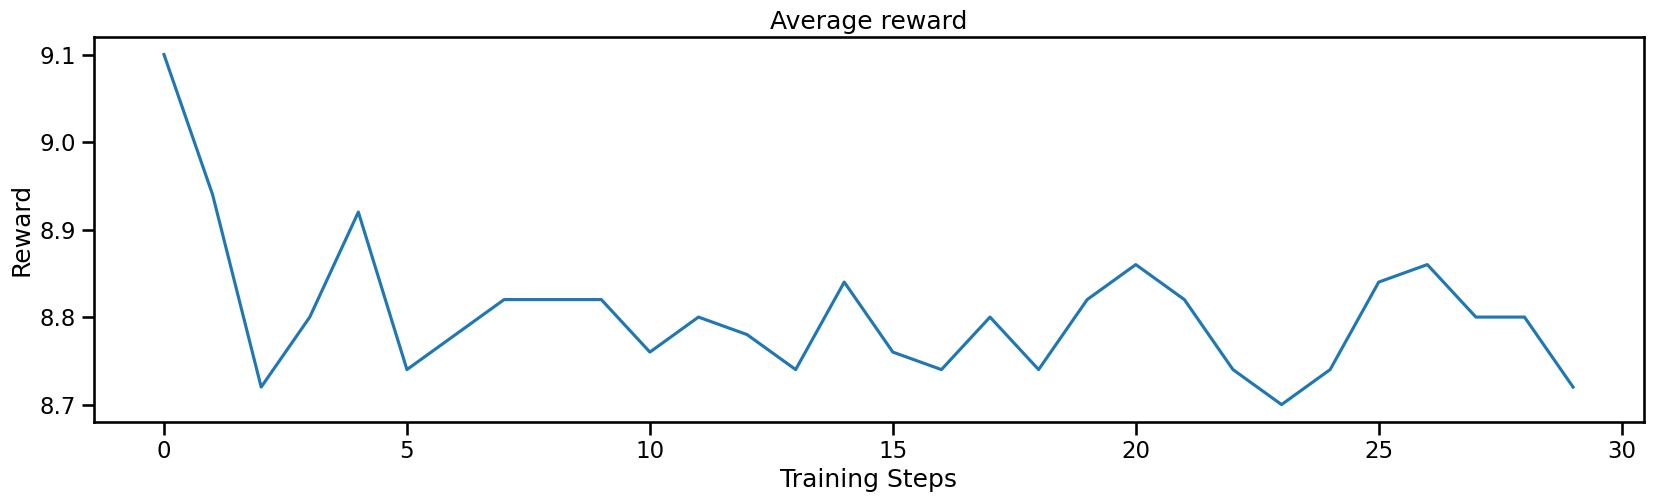

In [135]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "lab7_ex1_cem_cartpole_avg_reward_wrt_iterations.png");

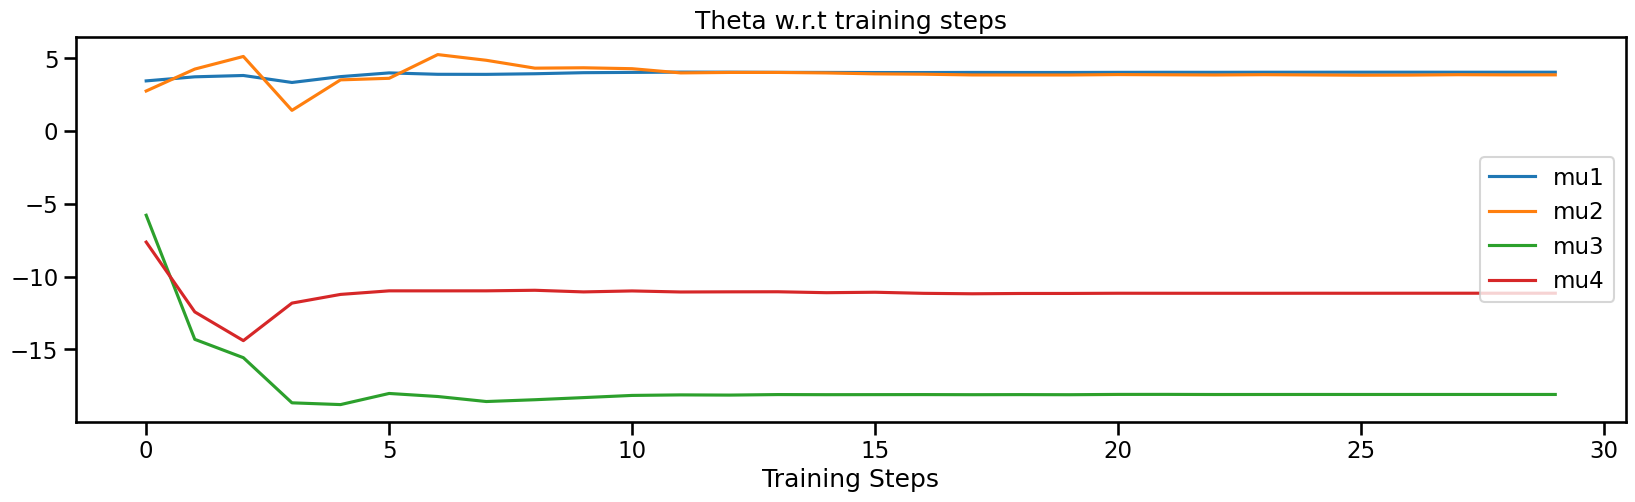

In [136]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
);
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex1_cem_cartpole_params_wrt_iterations.png");

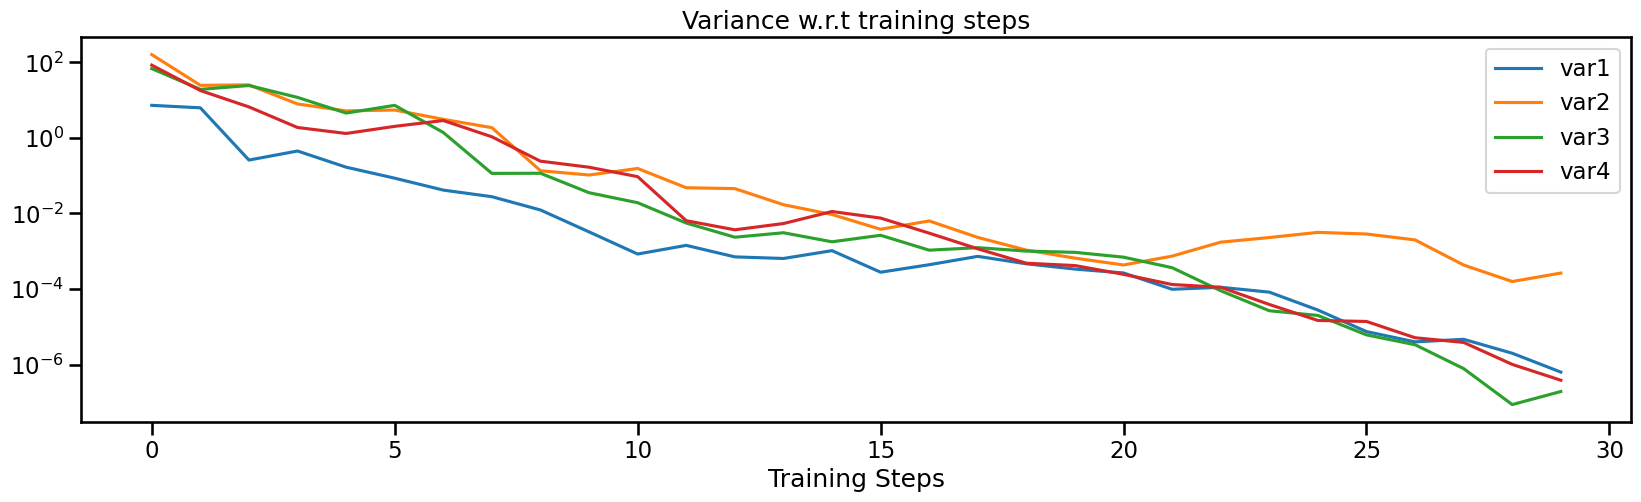

In [137]:
ax = df[["var1", "var2", "var3", "var4"]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex1_cem_cartpole_var_wrt_iterations.png");

In [138]:
print("Optimized weights: ", optimized_policy_params)

Optimized weights:  [  4.04210185   3.86075542 -18.10143787 -11.14307057]


### Test the trained agent

**Task 3:** test the optimized policy

In [139]:
VIDEO_PREFIX_EX1_CEM_CARTPOLE_TRAINED = "lab7_ex1_cem_cartpole_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX1_CEM_CARTPOLE_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX1_CEM_CARTPOLE_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=200)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex1_cem_cartpole_ta…

## Exercise 2: implement SAES and solve the CartPole problem with it

### Implement the (1+1)-SA-ES optimization algorithm

**Task 1**: Implement the `saes_1_1` function that search the best $\theta$ parameters with a (1+1)-SA-ES algorithm. Use the objective function defined above.

**(1+1)-SA-ES**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\boldsymbol{x}$: initial solution<br>

**Algorithm parameter**:<br>
$\quad\quad$ $\tau$: self-adaptation learning rate<br>

**FOR EACH** generation<br>
$\quad\quad$ 1. mutation of $\sigma$ (current individual strategy) : $\sigma' \leftarrow \sigma ~ e^{\tau \mathcal{N}(0,1)}$<br>
$\quad\quad$ 2. mutation of $\boldsymbol{x}$ (current solution) : $\boldsymbol{x}' \leftarrow \boldsymbol{x} + \sigma' ~ \mathcal{N}(0,1)$<br>
$\quad\quad$ 3. eval $f(\boldsymbol{x}')$<br>
$\quad\quad$ 4. survivor selection $\boldsymbol{x} \leftarrow \boldsymbol{x}'$ and $\sigma \leftarrow \sigma'$ if $f(\boldsymbol{x}') \leq f(\boldsymbol{x})$<br>

**RETURN** $\boldsymbol{x}$

In [140]:
def saes_1_1(
    objective_function: Callable[[np.ndarray], float],
    x_array: np.ndarray,
    sigma_array: np.ndarray,
    max_iterations: int = 500,
    tau: Optional[float] = None,
    print_every: int = 10,
    success_score: float = float("inf"),
    num_evals_for_stop: Optional[int] = None,
    hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    (1+1)-Self-Adaptive Evolution Strategy (SA-ES) optimization algorithm.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to minimize.
    x_array : np.ndarray
        The initial solution vector.
    sigma_array : np.ndarray
        The initial strategy parameter vector (step sizes).
    max_iterations : int, optional
        The maximum number of iterations, by default 500.
    tau : Optional[float], optional
        The self-adaptation learning rate, by default None.
    print_every : int, optional
        How often to print the current score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized solution vector.
    """
    # Number of dimension of the solution space
    d = x_array.shape[0]

    if tau is None:
        # Self-adaptation learning rate
        tau = 1.0 / (2.0 * d)

    score = objective_function(x_array)

    for iteration_index in range(0, max_iterations):
        # 1. Mutation of sigma (current "individual strategy")
        # new_sigma_array = ... # TODO...
        new_sigma_array = sigma_array * np.exp(tau * np.random.randn(d))

        # 2. Mutation of x (current solution)
        # new_x_array = ... # TODO...
        new_x_array = x_array + new_sigma_array * np.random.randn(d)

        # 3. Eval f(x')
        # new_score = ... # TODO...
        new_score = objective_function(new_x_array)

        # 4. survivor selection (we follow the ES convention and do minimization)
        if new_score <= score:  # You may try `new_score < score` for less exploration
            # score = ... # TODO...
            score = new_score
            # x_array = ... # TODO...
            x_array = new_x_array
            # sigma_array = ... # TODO...
            sigma_array = new_sigma_array

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + x_array.tolist() + sigma_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            score = ... # TODO...

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return x_array

### Train the agent

**Task 2:** train your implementation using the following cells.

In [141]:
env = gym.make("CartPole-v1")

nn_policy = LogisticRegression(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=nn_policy, num_episodes=10, max_time_steps=1000
)

In [142]:
%%time

hist_dict = {}

num_params = len(nn_policy.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    tau=0.001,
    max_iterations=1000,
    print_every=100,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

Iteration 0	Score -91.10000000000001
Iteration 100	Score -467.40000000000003
CPU times: user 10.4 s, sys: 47.2 ms, total: 10.4 s
Wall time: 14.6 s


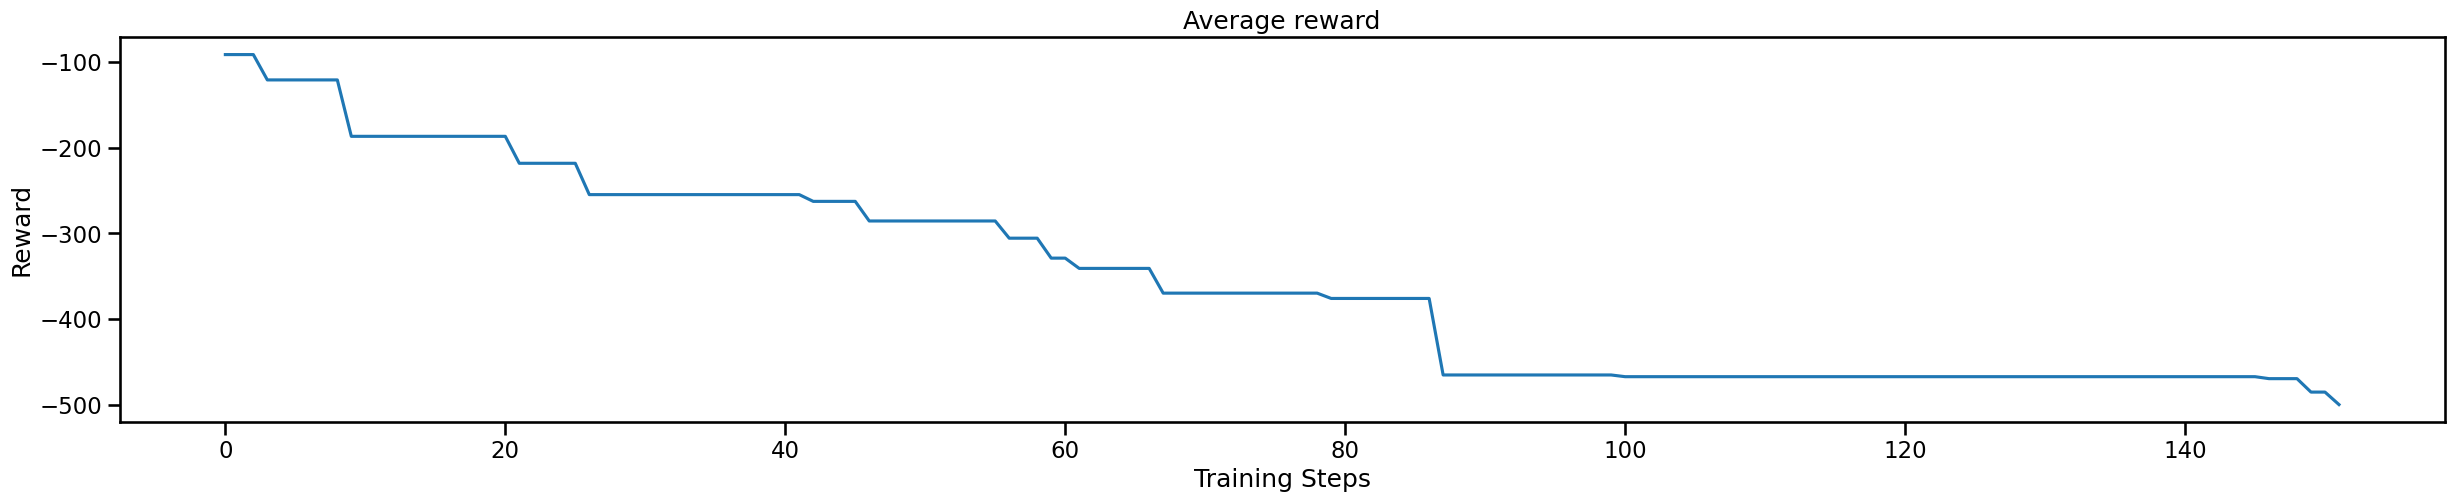

In [143]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=[
        "score",
        "mu1",
        "mu2",
        "mu3",
        "mu4",
        "sigma1",
        "sigma2",
        "sigma3",
        "sigma4",
    ],
)
ax = df.score.plot(title="Average reward", figsize=(30, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "lab7_ex2_saes_cartpole_avg_reward_wrt_iterations.png");

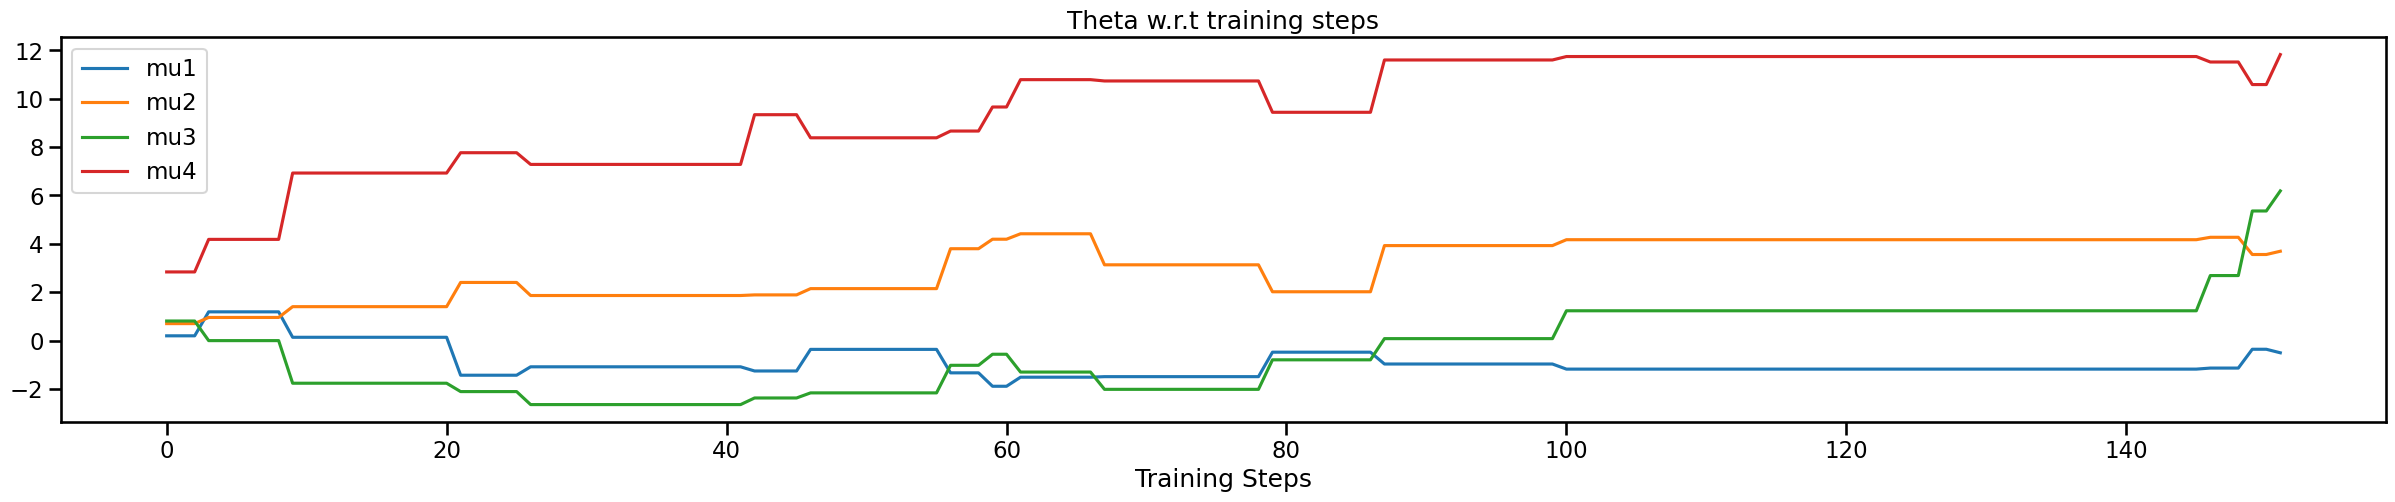

In [144]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex2_saes_cartpole_params_wrt_iterations.png");

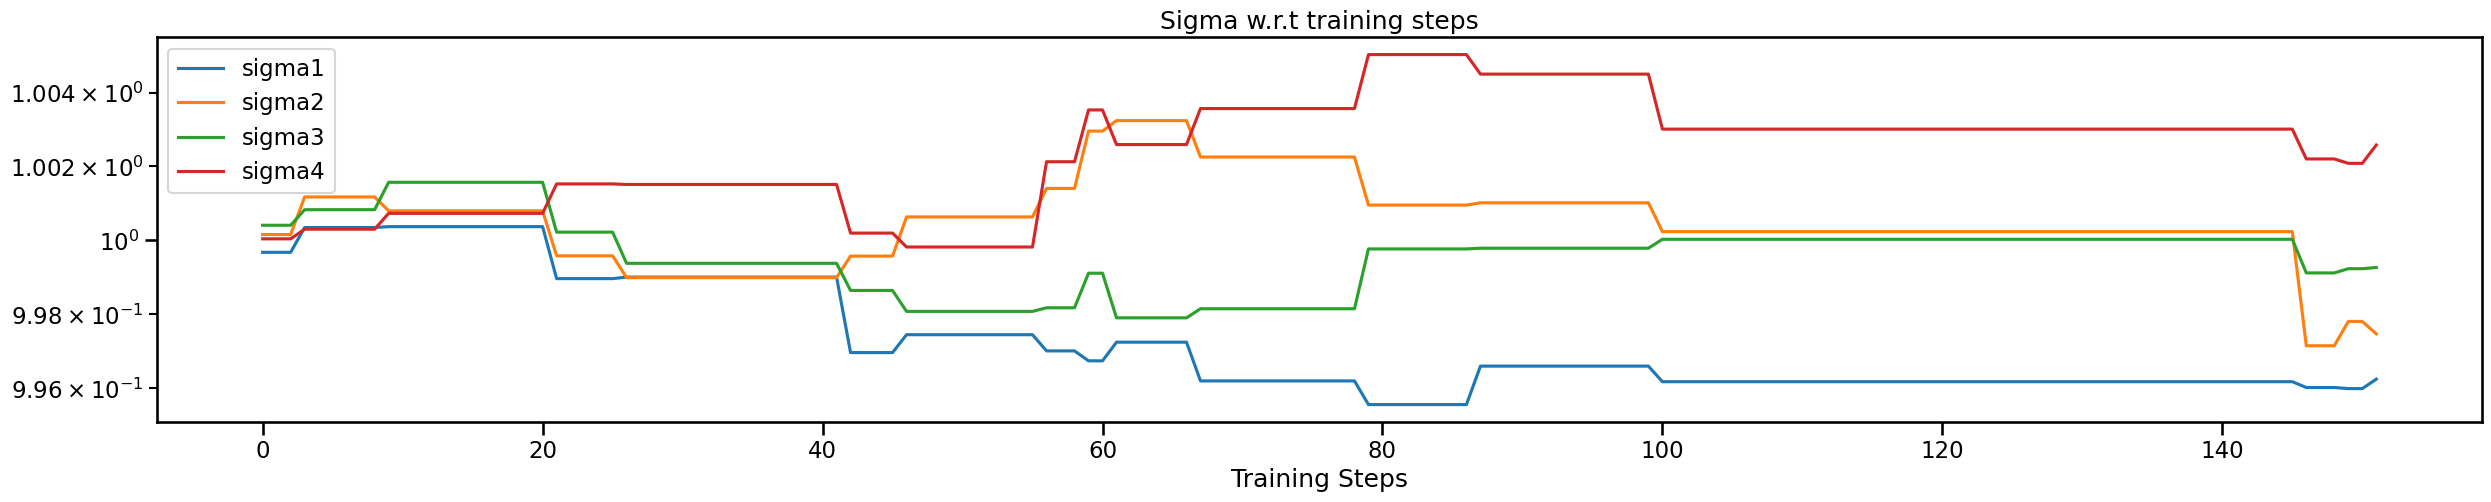

In [145]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(
    logy=True, title="Sigma w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex2_saes_cartpole_var_wrt_iterations.png");

In [146]:
print("Optimized weights: ", optimized_policy_params)

Optimized weights:  [-0.50440732  3.69323639  6.18678296 11.82256946]


### Test the trained agent

**Task 3:** test the optimized policy

In [147]:
VIDEO_PREFIX_EX2_SAES_CARTPOLE_TRAINED = "lab7_ex2_saes_cartpole_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX2_SAES_CARTPOLE_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX2_SAES_CARTPOLE_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=200)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex2_saes_cartpole_t…

**Task 4:** try different values of $\tau$. What happen ?

## Exercise 3: Implement a parametric policy $\pi_\theta$ for environments having a continuous action space

To solve problems having a continuous space, especially to solve the LunarLander problem in the next exercise, we need to define and implement an appropriate parametric policy.
For this purpose, we recommend the following neural network:
- one hidden layer of 16 units having a ReLu activation function
- a tanh activation function on the output layer (be careful on the number of output units)

To solve environments with continuous action space like LunarLander with Direct Policy Search methods, a simple procedure that compute the feed forward signal is needed (we don't do back propagation here).
A procedure to set/get weights of the network from/to a single vector $\theta$ will also be required.

In [148]:
class NeuralNetworkPolicy(torch.nn.Module):
    """
    A neural network used as a policy.

    Attributes
    ----------
    hidden_layer : torch.nn.Linear
        The hidden layer of the neural network.
    output_layer : torch.nn.Linear
        The output layer of the neural network.

    Methods
    -------
    forward(observation: torch.Tensor) -> np.ndarray
        Define the forward pass of the NeuralNetworkPolicy.
    get_params() -> np.ndarray
        Get the parameters of the neural network.
    set_params(params: np.ndarray) -> None
        Set the parameters of the neural network.
    """

    def __init__(
        self, observations_size: int, actions_size: int, hidden_size: int = 16
    ):
        """
        Initialize a new instance of NeuralNetworkPolicy.

        Parameters
        ----------
        observations_size : int
            The size of the observation space (i.e. the number of features i.e. the number of elements in the observation vector).
        actions_size : int
            The size of the action space.
        hidden_size : int, optional
            The number of units in the hidden layer, by default 16.
        """
        super(NeuralNetworkPolicy, self).__init__()

        # self.hidden_layer = ... # TODO...
        self.hidden_layer = torch.nn.Linear(observations_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, actions_size)
        # self.output_layer = ... # TODO...

    def forward(self, observation: torch.Tensor) -> np.ndarray:
        """
        Calculate the probability of action a_1 for the given observation.

        Parameters
        ----------
        observation : torch.Tensor
            The input tensor (observation).
            The shape of the tensor should be (N, dim),
            where N is the number of observations vectors in the batch
            and dim is the dimension of observation vectors.

        Returns
        -------
        np.ndarray
            The output tensor (the probability of each action for the given observation).
        """
        with torch.no_grad():
            # observation_tensor = ... # TODO...
            observation_tensor = torch.tensor(observation, dtype=torch.float32, device=device)
            # hidden_tensor = ... # TODO...
            hidden_tensor = torch.relu(self.hidden_layer(observation_tensor))
            # output_tensor = ... # TODO...
            output_tensor = torch.tanh(self.output_layer(hidden_tensor))
            return output_tensor.squeeze().detach().cpu().numpy()

    def get_params(self) -> np.ndarray:
        """
        Get the parameters of the neural network.

        Returns
        -------
        np.ndarray
            The parameters of the neural network.
        """
        params_tensor = torch.nn.utils.parameters_to_vector(self.parameters())
        return params_tensor.detach().cpu().numpy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters of the neural network.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the neural network.
        """
        params_tensor = torch.tensor(params, dtype=torch.float32, device=device)
        torch.nn.utils.vector_to_parameters(params_tensor, self.parameters())

## Exercise 4: solve the LunarLander problem (continuous version) with CEM and SAES

### Hands on the LunarLander problem

**Task 1:** read https://gymnasium.farama.org/environments/box2d/lunar_lander/ to discover the LunarLanderContinuous environment.

**Notice:** A reminder of Gymnasium main concepts is available at https://gymnasium.farama.org/introduction/basic_usage/.

Print some information about the environment:

In [149]:
env = gym.make("LunarLander-v3", continuous=True)
print("Observation space dimension is:", env.observation_space.shape[0])
print("Observation upper bounds:", env.observation_space.high)
print("Observation lower bounds:", env.observation_space.low)
print("Actions upper bounds:", env.action_space.high)
print("Actions lower bounds:", env.action_space.low)
env.close()

Observation space dimension is: 8
Observation upper bounds: [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]
Observation lower bounds: [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
Actions upper bounds: [1. 1.]
Actions lower bounds: [-1. -1.]


**Task 2:** Run the following cells and check different basic policies (for instance constant actions or randomly drawn actions) to discover the Lunar Lander environment.

In [150]:
VIDEO_PREFIX_EX4_UNTRAINED = "lab7_ex4_lunarlander_untrained"

(FIGS_DIR / f"{VIDEO_PREFIX_EX4_UNTRAINED}-episode-0.mp4").unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=str(FIGS_DIR), name_prefix=VIDEO_PREFIX_EX4_UNTRAINED)

observation, info = env.reset()
done = False

while not done:
    # action = np.array([1., 1.])
    action = np.array([-1.0, -1.0])
    # action = env.action_space.sample()   # Random policy

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

Video(
    FIGS_DIR / f"{VIDEO_PREFIX_EX4_UNTRAINED}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)

**Note**: If you encounter a dependency issue with *swig*, follow the procedure outlined at https://gymnasium.farama.org/environments/box2d/

**Question 1:** We want to use CEM and SAES to compute the optimal policy for the Lunar Lander environment.
What is the size of the search space (number of dimensions) for optimizers knowing that the policy is the one defined in exercise 3 (a neural network of one hidden layer of 16 neurons) and knowing that the observation space of the Lunar Lander environment is $\mathcal{S} = \mathbb{R}^8$ and its action space is $\mathcal{A} \subset \mathbb{R}^2$ ?

In [151]:
# **Question 1:** We want to use CEM and SAES to compute the optimal policy for the Lunar Lander environment.
# What is the size of the search space (number of dimensions) for optimizers knowing that the policy is the one defined in exercise 3 (a neural network of one hidden layer of 16 neurons) and knowing that the observation space of the Lunar Lander environment is $\mathcal{S} = \mathbb{R}^8$ and its action space is $\mathcal{A} \subset \mathbb{R}^2$ ?
# TODO...


### Train the CEM agent on the LunarLander environment

**Task 3:** Train the agent using the CEM algorithm

In [152]:
env = gym.make("LunarLander-v3", continuous=True)

nn_policy = NeuralNetworkPolicy(
    observations_size=env.observation_space.shape[0],
    actions_size=env.action_space.shape[0],
    hidden_size=16,
)

objective_function = ObjectiveFunction(
    env=env, policy=nn_policy, num_episodes=3, max_time_steps=500
)

In [153]:
%%time

hist_dict = {}

num_params = len(nn_policy.get_params())

init_mean_array = np.random.random(num_params)
init_var_array = np.ones(num_params) * 1000.0

optimized_policy_params = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=100,
    sample_size=50,
    elite_frac=0.2,
    print_every=1,
    success_score=-200,
    hist_dict=hist_dict,
)

objective_function.env.close()

Iteration 0	Score -1137.7785412189921
CPU times: user 2.93 s, sys: 116 ms, total: 3.04 s
Wall time: 2.93 s


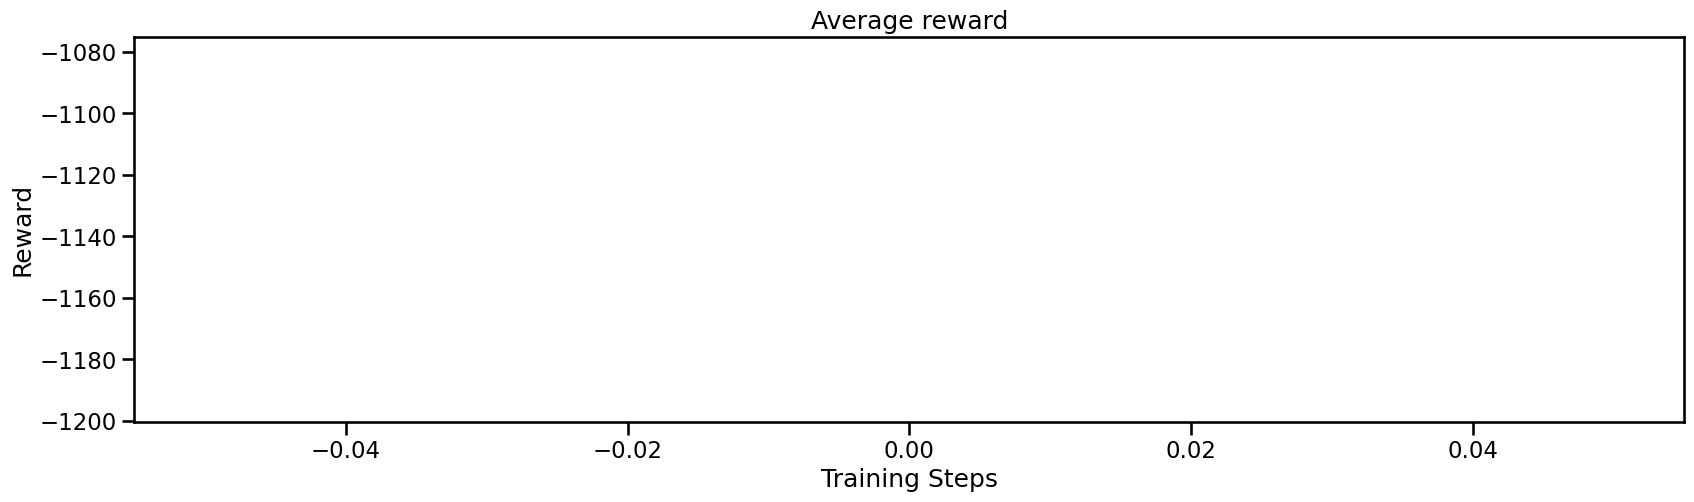

In [154]:
df = pd.DataFrame.from_dict(hist_dict, orient="index")
ax = df.iloc[:, 0].plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "lab7_ex4_cem_lunarlander_avg_reward_wrt_iterations.png");

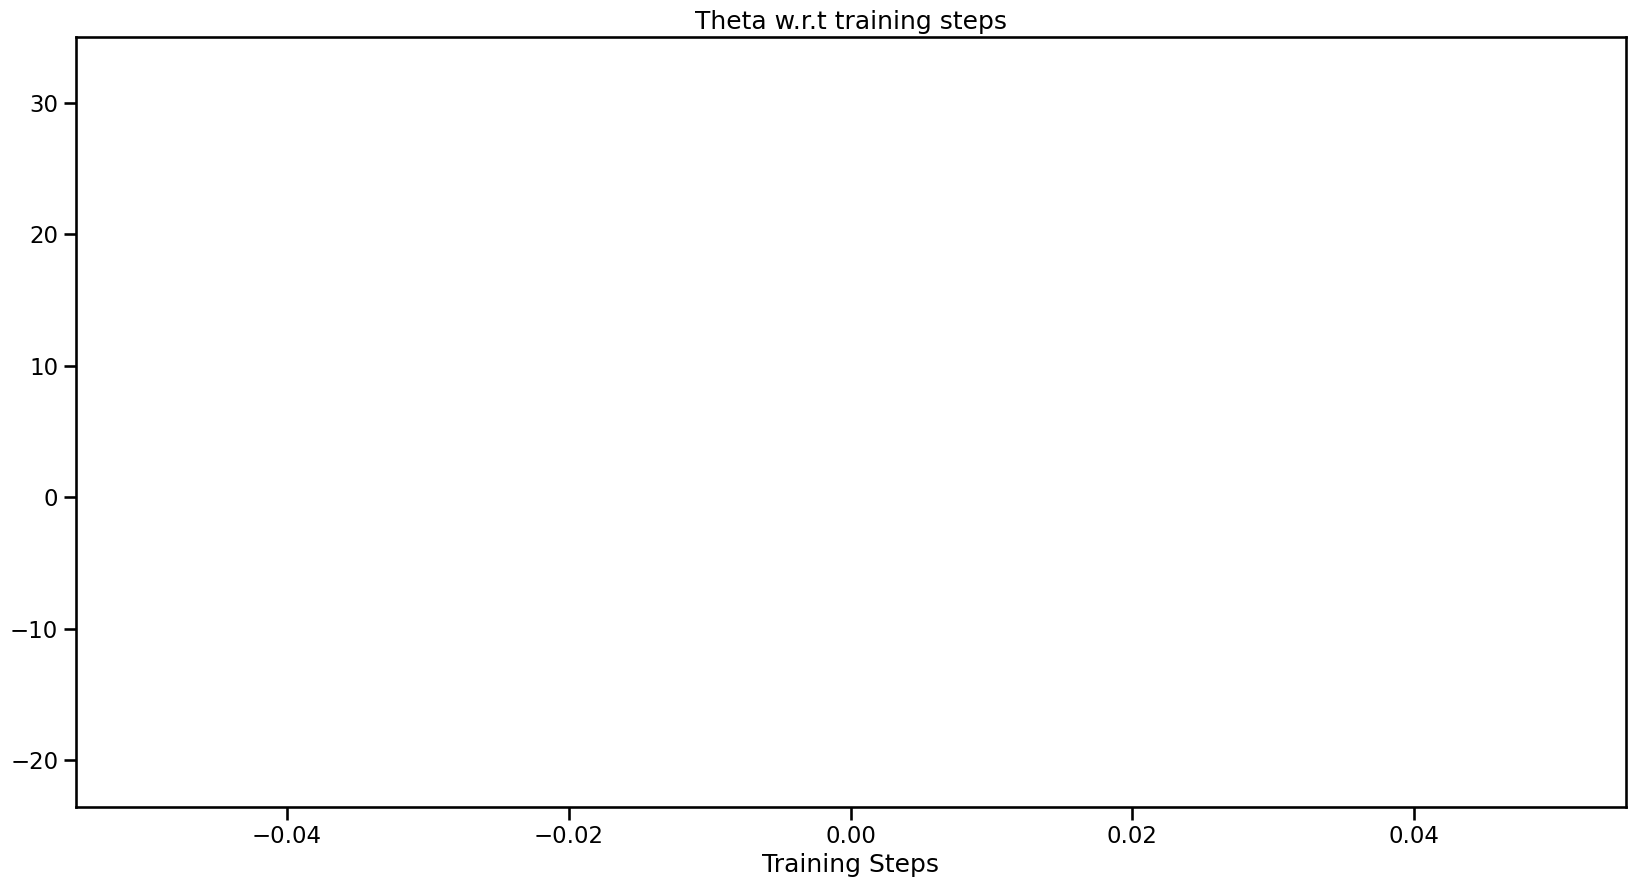

In [155]:
ax = df.iloc[:, 1:66].plot(
    title="Theta w.r.t training steps", legend=None, figsize=(20, 10)
)
# ax.get_legend().remove()
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex4_cem_lunarlander_params_wrt_iterations.png");

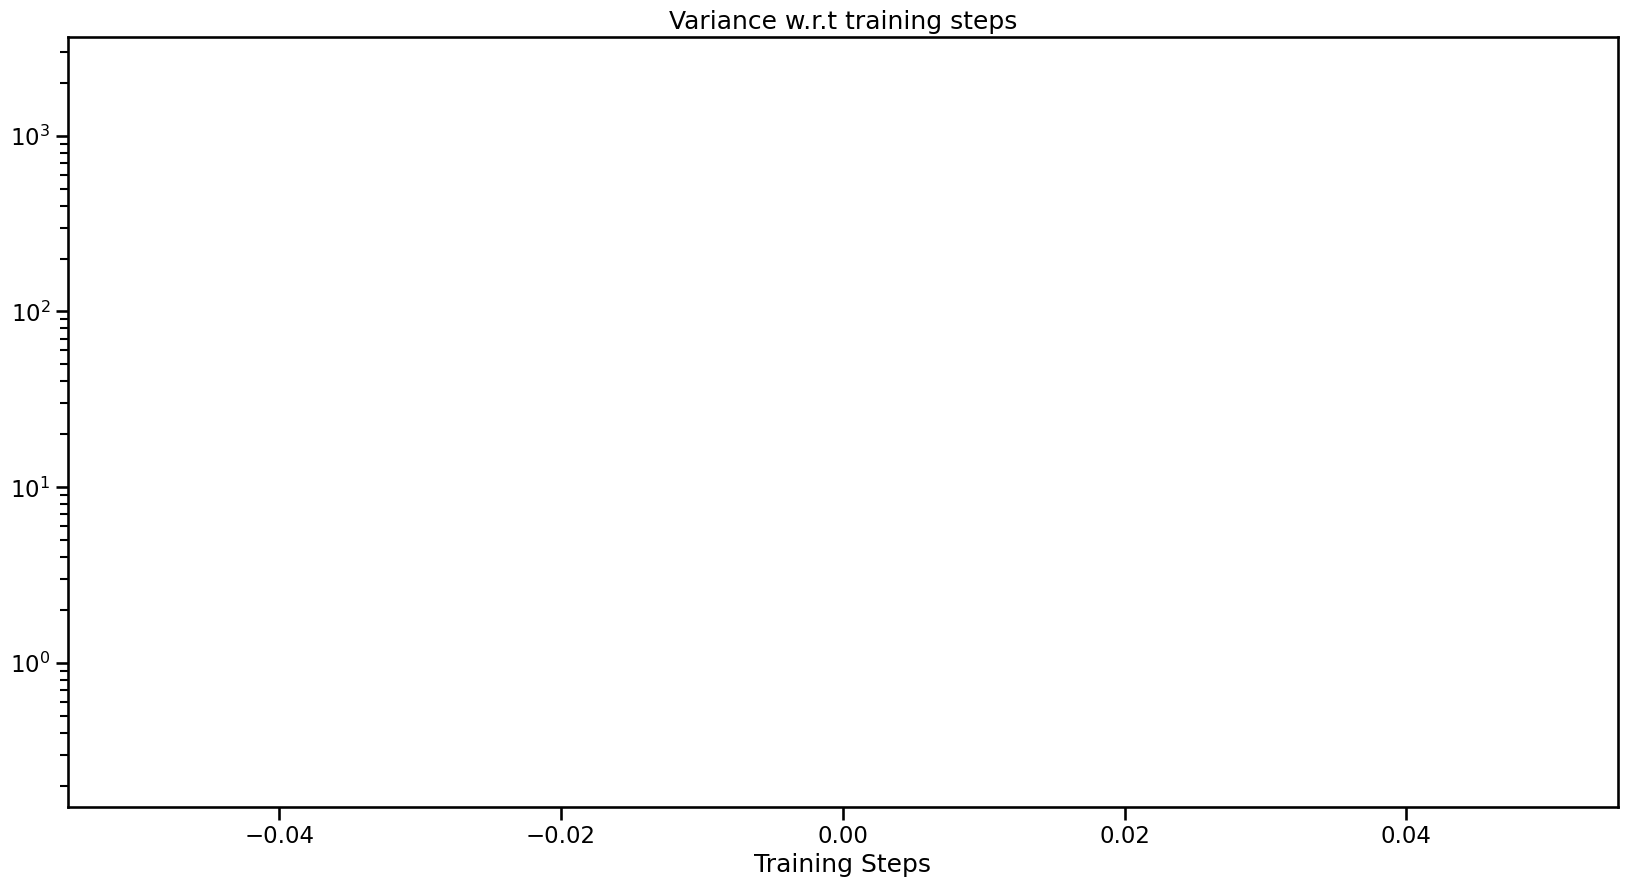

In [156]:
ax = df.iloc[:, 67:].plot(
    logy=True, title="Variance w.r.t training steps", legend=None, figsize=(20, 10)
)
# ax.get_legend().remove()
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex4_cem_lunarlander_var_wrt_iterations.png");

In [157]:
print("Optimized weights: ", optimized_policy_params)

Optimized weights:  [-1.41937899e+01 -4.43566981e+00 -3.57335560e+00  5.48066699e+00
  1.30146079e+01 -1.03767515e+00  2.70985433e+00  3.26249451e+00
 -1.10746119e+01  2.43689558e-02  3.23192176e+01  2.09686191e+00
 -5.69825627e+00  8.38817270e+00 -3.73831214e+00  2.11278343e+00
 -7.74338777e+00  8.55411890e+00  1.25651414e+01 -1.36456617e+01
  5.16385085e+00 -2.64366533e+00 -9.03322720e+00  1.32030122e+01
  4.86801465e+00  1.33664252e+01 -1.43324664e+01 -1.08081781e+01
  2.75432724e+01  9.48184254e+00 -2.42146758e+00  9.02609930e+00
 -2.09046510e+01 -3.00848562e+00 -5.71979117e+00 -1.16526427e+01
 -2.20007569e+00 -3.15712400e+00  4.19316194e+00 -1.44278065e+01
 -4.24830116e+00  6.19088954e-01 -1.70295994e+01  7.46671771e+00
  6.27567501e+00 -2.38843238e+00 -3.67153525e+00 -7.96875937e+00
 -9.55723852e+00 -1.99996701e+01 -4.10563333e+00 -3.30452089e+00
  4.19584585e+00  1.58588648e+01 -3.46781457e-01  3.06694315e+00
  1.71350741e+00 -1.58120662e+01 -4.21294223e+00  5.54341498e+00
 -8.0

### Test the trained agent

**Task 4:** check the optimized policy.

In [158]:
VIDEO_PREFIX_EX4_CEM_LUNARLANDER_TRAINED = "lab7_ex4_cem_lunarlander_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX4_CEM_LUNARLANDER_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX4_CEM_LUNARLANDER_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=500)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex4_cem_lunarlander…

### Train the (1+1)-SA-ES agent on the LunarLander environment

**Task 5:** Train the agent using the (1+1)-SA-ES algorithm

In [159]:
env = gym.make("LunarLander-v3", continuous=True)

nn_policy = NeuralNetworkPolicy(
    observations_size=env.observation_space.shape[0],
    actions_size=env.action_space.shape[0],
    hidden_size=16,
)

objective_function = ObjectiveFunction(
    env=env,
    policy=nn_policy,
    num_episodes=5,  # <- resampling
    max_time_steps=500,
)

In [160]:
%%time

hist_dict = {}

num_params = len(nn_policy.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    max_iterations=1000,
    print_every=10,
    success_score=-200,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

objective_function.env.close()

Iteration 0	Score 958.8500086994643
Iteration 10	Score 623.3327367401537
Iteration 20	Score 473.8472135873551
Iteration 30	Score 473.8472135873551
Iteration 40	Score 448.16373368717586
Iteration 50	Score 448.16373368717586
Iteration 60	Score 448.16373368717586
Iteration 70	Score 326.66765263173266
Iteration 80	Score 184.94688682164173
Iteration 90	Score 118.62595023131996
Iteration 100	Score 115.89349924197953
Iteration 110	Score 96.93148633136335
Iteration 120	Score 58.531561038434944
Iteration 130	Score 58.531561038434944
Iteration 140	Score 58.531561038434944
Iteration 150	Score 58.531561038434944
Iteration 160	Score 42.04115587071346
Iteration 170	Score 42.04115587071346
Iteration 180	Score 4.048730196209189
Iteration 190	Score -1.1451838034730226
Iteration 200	Score -41.86335457997501
Iteration 210	Score -41.86335457997501
Iteration 220	Score -172.1311794841739
Iteration 230	Score -172.1311794841739
Iteration 240	Score -172.1311794841739
Iteration 250	Score -172.1311794841739
Iter

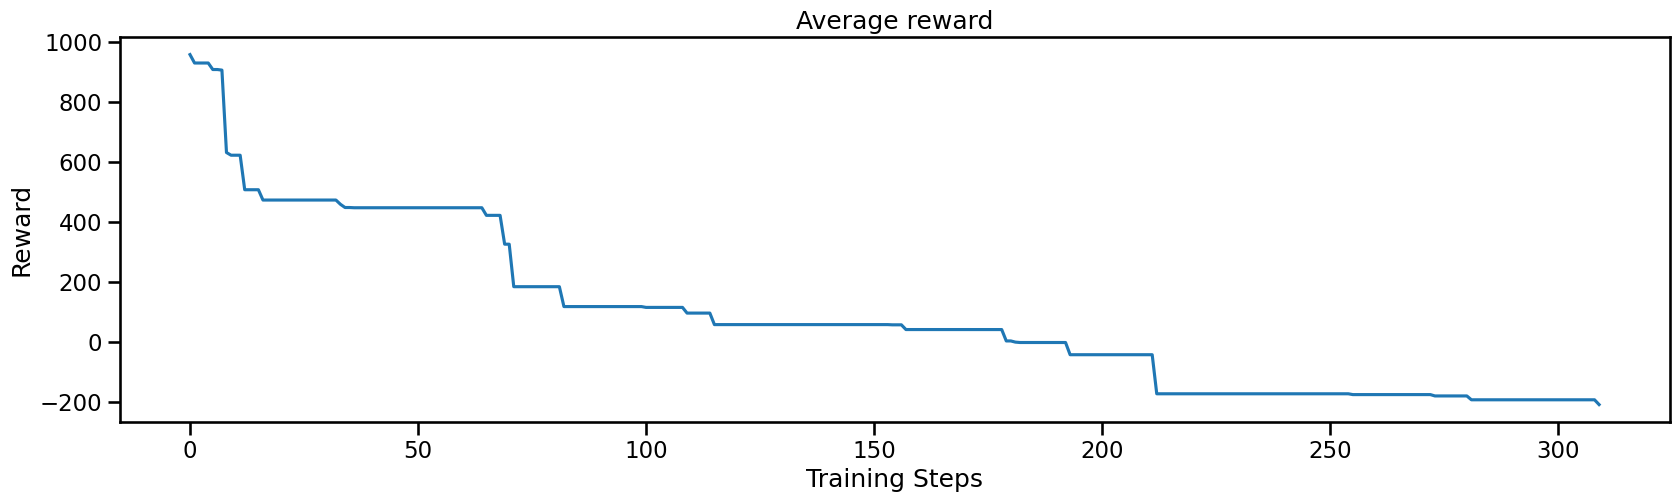

In [161]:
df = pd.DataFrame.from_dict(hist_dict, orient="index")
ax = df.iloc[:, 0].plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "lab7_ex4_saes_lunarlander_avg_reward_wrt_iterations.png");

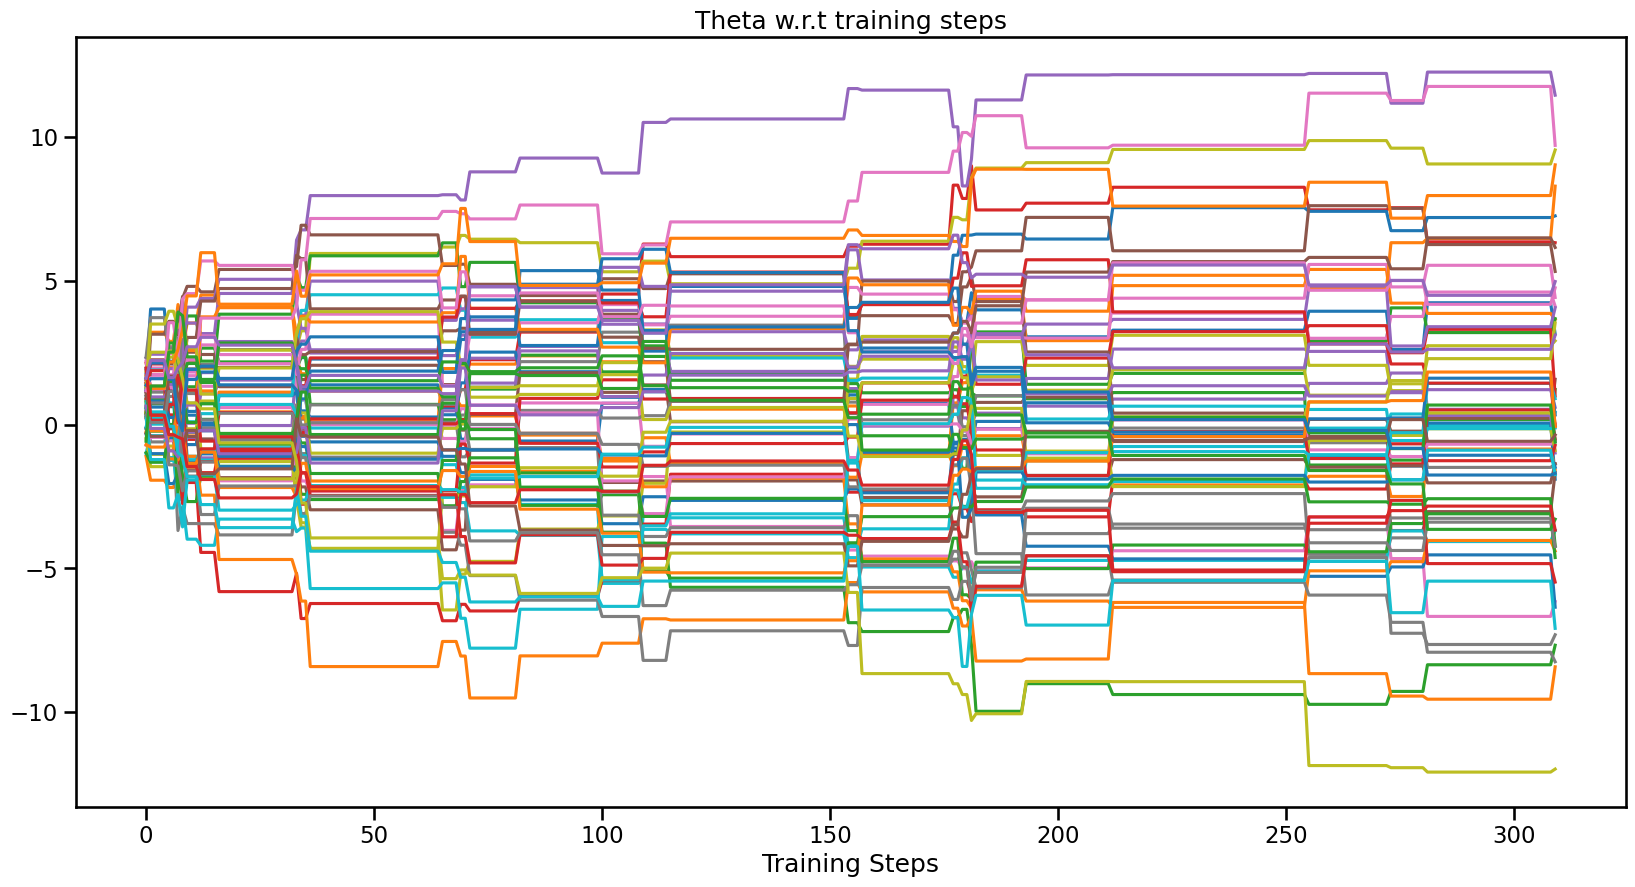

In [162]:
ax = df.iloc[:, 1:66].plot(
    title="Theta w.r.t training steps", legend=None, figsize=(20, 10)
)
# ax.get_legend().remove()
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex4_saes_lunarlander_params_wrt_iterations.png");

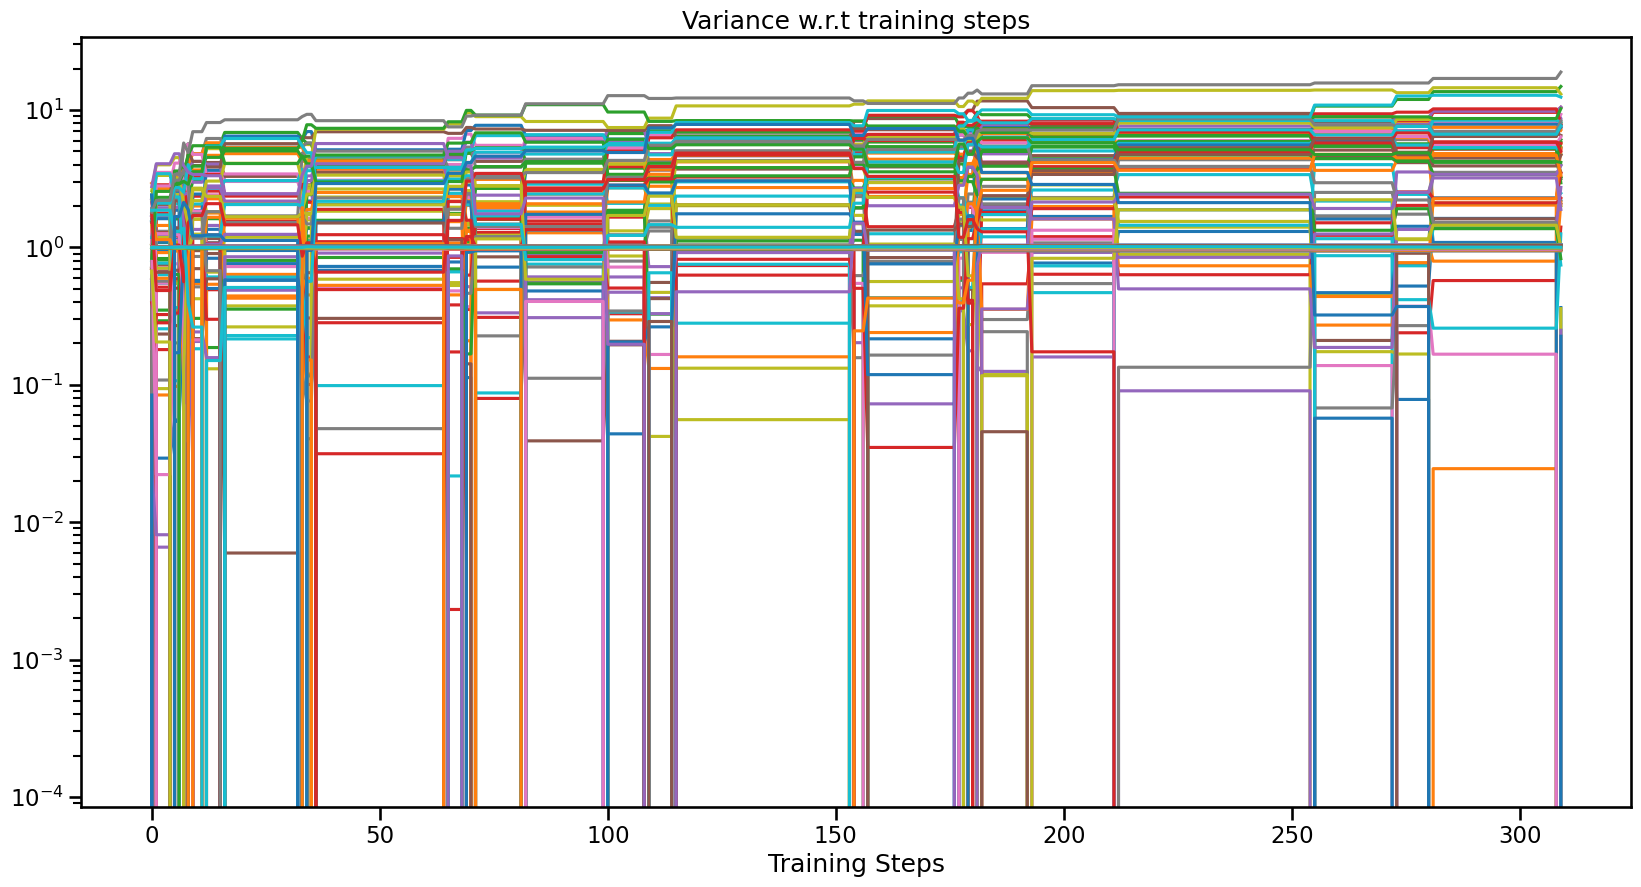

In [163]:
ax = df.iloc[:, 67:].plot(
    logy=True, title="Variance w.r.t training steps", legend=None, figsize=(20, 10)
)
# ax.get_legend().remove()
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex4_saes_lunarlander_var_wrt_iterations.png");

In [164]:
print("Optimized weights: ", optimized_policy_params)

Optimized weights:  [  3.15326853   3.65612431   1.22345175   6.32767662  -0.5934574
   1.57858475  -6.15153132  -1.37123535   9.55280522   0.42764641
  -1.89676727  -1.55702633   3.68577774  -0.50261302  -0.98460656
  -1.65884824   4.11837995  -4.24613459   2.91507005  -3.67778137
  -6.34807942  -4.39259624  -7.6689664    0.99602428  11.45764907
  -1.35542302   0.02731082  -8.24446073  -0.89888803  -0.11257178
   7.25959923  -8.42074054  -4.62014525  -0.72170376   4.06604177
   5.32817052   4.42405683  -7.30626671  -0.04477303   0.90467654
  -1.48495695   8.29524439  -4.21030641  -0.04665199   0.60191065
   6.16272344   9.71234671  -3.67880635   3.54193315  -1.73644562
   0.3381872   -0.06781182  -0.60698734  -5.47352856   3.11261404
  -0.35486979   4.75933325  -4.23681011 -11.9758086   -7.08270559
  -1.69360537   9.03496744  -3.2874169   -3.66052395   4.97686317
   2.96534291   0.36500202  -0.76962792   3.25235186   1.40623376
  -0.02410739   7.37827537   9.30113925  -4.02285053  -0.

### Test the trained agent

**Task 6:** check the optimized policy.

In [165]:
VIDEO_PREFIX_EX4_SAES_LUNARLANDER_TRAINED = "lab7_ex4_saes_lunarlander_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX4_SAES_LUNARLANDER_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX4_SAES_LUNARLANDER_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=500)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex4_saes_lunarlande…

## Bonus exercise 1: implement CEM with an alternative *Proposal distribution*

Implement CEM with the following alternative *Proposal distribution*: a multivariate normal distribution parametrized by a mean vector and **a covariance matrix** (to use correlations in the search space dimensions).

Test it on the CartPole and the LunarLander environments.

In [166]:
def cem_correlated(
    objective_function: Callable[[np.ndarray], float],
    mean_array: np.ndarray,
    var_array: np.ndarray,
    max_iterations: int = 500,
    sample_size: int = 50,
    elite_frac: float = 0.2,
    print_every: int = 10,
    success_score: float = float("inf"),
    num_evals_for_stop: Optional[int] = None,
    hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """Cross-entropy method.

    Params
    ======
        objective_function (function): the function to maximize
        mean_array (array of floats): the initial proposal distribution (mean vector)
        var_array (array of floats): the initial proposal distribution (variance vector)
        max_iterations (int): number of training iterations
        sample_size (int): size of population at each iteration
        elite_frac (float): rate of top performers to use in update with elite_frac ∈ ]0;1]
        print_every (int): how often to print average score
        hist_dict (dict): logs
    """
    assert 0.0 < elite_frac <= 1.0

    n_elite = math.ceil(sample_size * elite_frac)

    cov_array = np.diag(var_array)

    for iteration_index in range(0, max_iterations):
        # SAMPLE A NEW POPULATION OF SOLUTIONS (X VECTORS) ####################

        # x_array = ... # TODO...
        x_array = np.random.multivariate_normal(mean_array, cov_array, size=sample_size)

        # EVALUATE SAMPLES AND EXTRACT THE BEST ONES ("ELITE") ################

        # score_array = ... # TODO...
        score_array = np.array([objective_function(x) for x in x_array])

        # sorted_indices_array = ... # TODO...             # Sort from the lower score to the higher one
        sorted_indices_array = np.argsort(score_array)
        # elite_indices_array = ... # TODO...     # Recall: we *minimize* the objective function thus we take the samples that are at the begining of the sorted_indices
        elite_indices_array = sorted_indices_array[:n_elite]

        # elite_x_array = ... # TODO...
        elite_x_array = x_array[elite_indices_array]

        # FIT THE NORMAL DISTRIBUTION ON THE ELITE POPULATION #################

        # mean_array = ... # TODO...
        mean_array = np.mean(elite_x_array, axis=0)
        # cov_array = ... # TODO...
        cov_array = np.cov(elite_x_array.T)
        # score = ... # TODO...
        score = objective_function(mean_array)

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + cov_array.flatten().tolist()

        # STOPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            # score = ... # TODO...
            score = objective_function(mean_array)
            if iteration_index >= num_evals_for_stop:
                break

        # `num_evals_for_stop = None` may be used to fasten computations but it introduce bias...
        if score <= success_score:
            break

    return mean_array

### Test on CartPole

In [167]:
env = gym.make("CartPole-v1")

nn_policy = LogisticRegression(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=nn_policy, num_episodes=10, max_time_steps=1000
)

In [168]:
%%time

hist_dict = {}

num_params = len(nn_policy.get_params())

init_mean_array = np.random.random(num_params)
init_var_array = np.ones(num_params) * 100.0

optimized_policy_params = cem_correlated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

objective_function.env.close()

Iteration 0	Score -389.90000000000003
Iteration 1	Score -446.7
Iteration 2	Score -478.9
Iteration 3	Score -500.0
CPU times: user 13.3 s, sys: 115 ms, total: 13.4 s
Wall time: 13.5 s


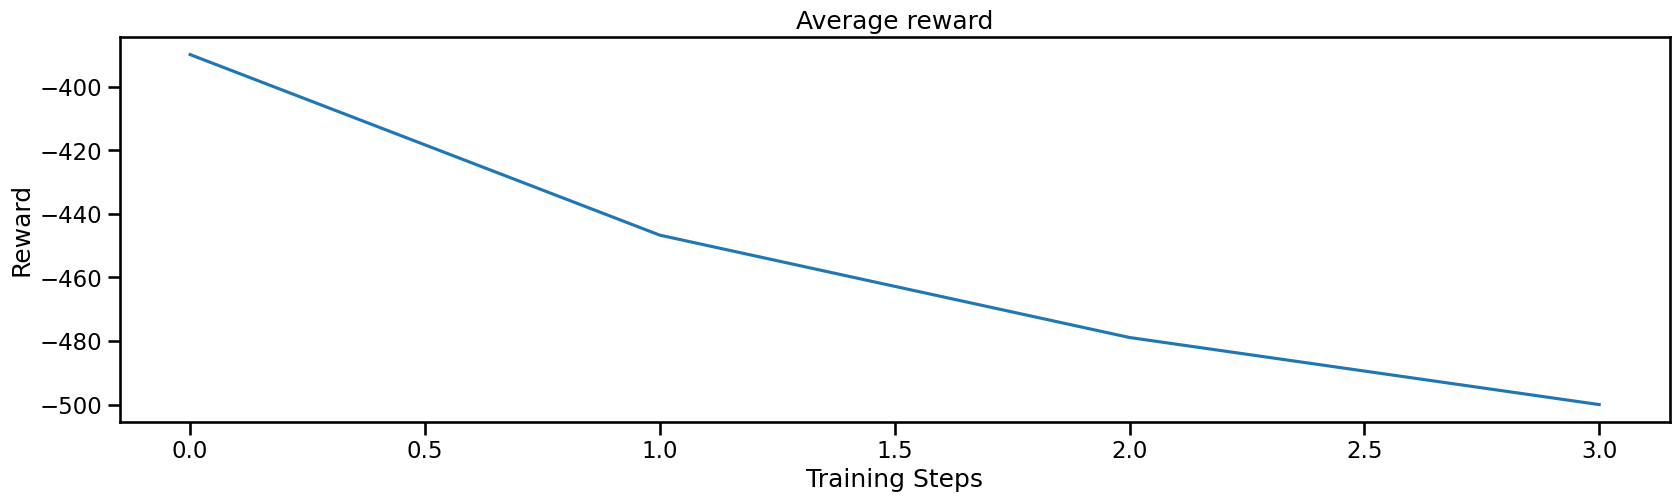

In [169]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score"]
    + [f"mu{i}" for i in range(1, 5)]
    + [f"cov{i}{j}" for i in range(1, 5) for j in range(1, 5)],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "lab7_ex5_cem_cartpole_avg_reward_wrt_iterations.png");

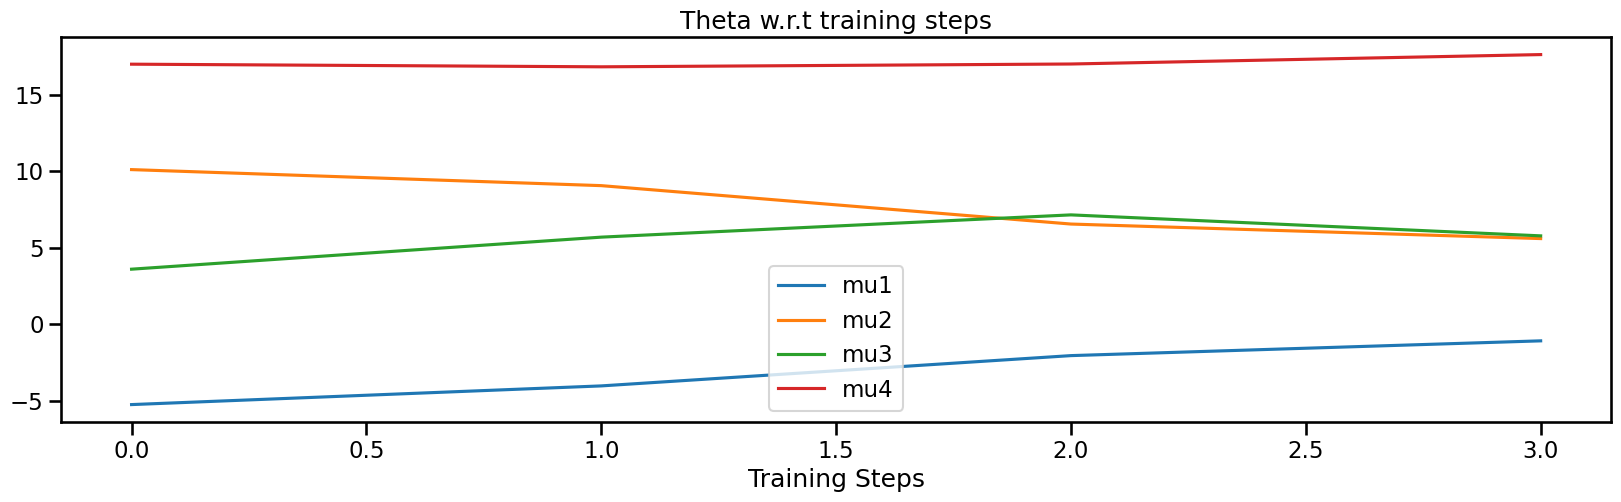

In [170]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex5_cem_cartpole_params_wrt_iterations.png");

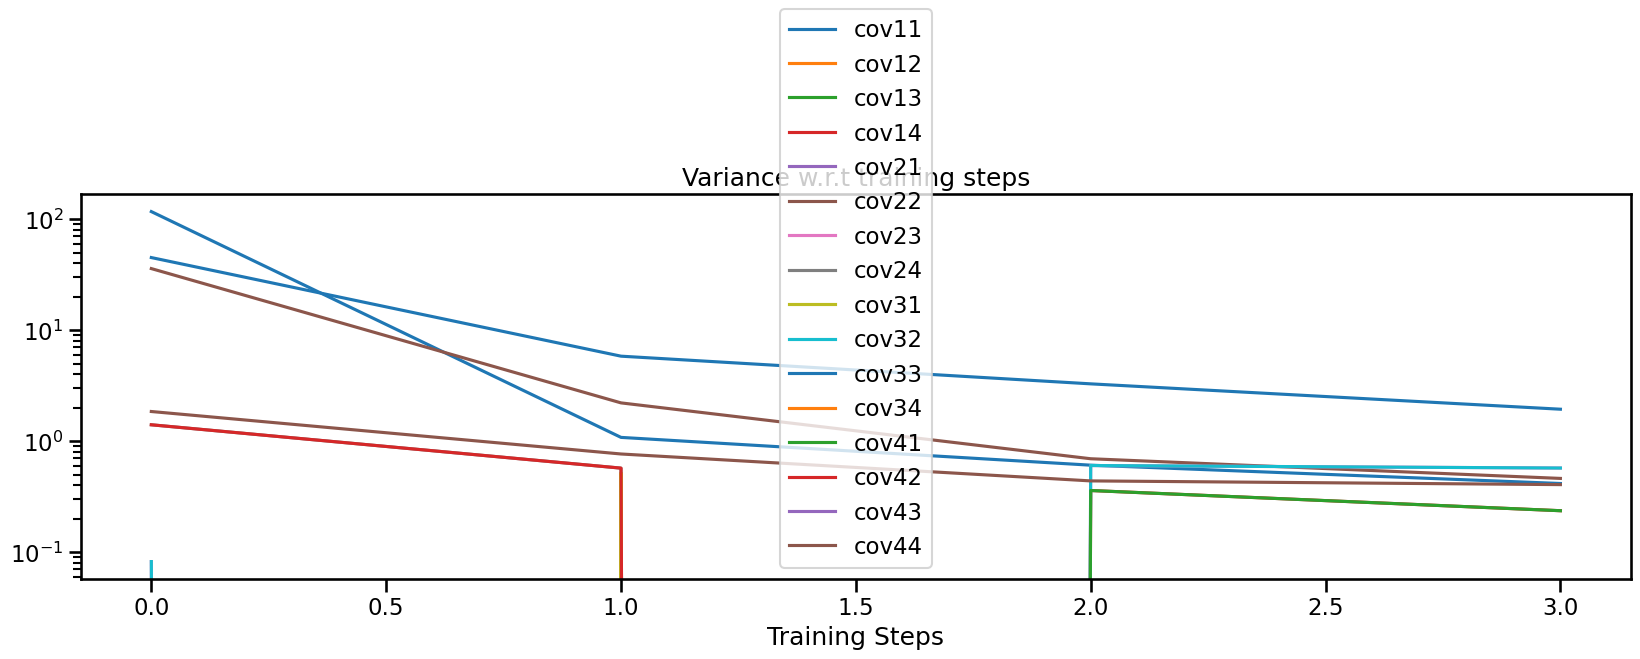

In [171]:
ax = df[[f"cov{i}{j}" for i in range(1, 5) for j in range(1, 5)]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "lab7_ex5_cem_cartpole_var_wrt_iterations.png");

In [172]:
print("Optimized weights: ", optimized_policy_params)

Optimized weights:  [-1.09238169  5.59377278  5.77188669 17.62307646]


In [173]:
VIDEO_PREFIX_EX5_CEM_CARTPOLE_TRAINED = "lab7_ex5_cem_cartpole_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX5_CEM_CARTPOLE_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX5_CEM_CARTPOLE_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=500)

env.close()

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex5_cem_cartpole_ta…

## Bonus exercise 2: test the CMAES algorithm

PyCMA: Python implementation of CMA-ES (from Nikolaus Hansen - CMAP).

Source code:

- http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#python
- https://github.com/CMA-ES/pycma
- https://pypi.org/project/cma/

Official documentation:

- http://cma.gforge.inria.fr/apidocs-pycma/

In [174]:
import cma

In [175]:
env = gym.make("LunarLander-v3", continuous=True)

nn_policy = NeuralNetworkPolicy(
    observations_size=env.observation_space.shape[0],
    actions_size=env.action_space.shape[0],
    hidden_size=16,
)

objective_function = ObjectiveFunction(
    env=env, policy=nn_policy, num_episodes=1, max_time_steps=500
)

In [176]:
%%time

num_params = len(nn_policy.get_params())

x_optimal, es = cma.fmin2(
    objective_function,
    x0=np.random.random(num_params),
    sigma0=10.0,
    options={"maxfevals": 1500},
)
optimized_policy_params = x_optimal

(9_w,19)-aCMA-ES (mu_w=5.6,w_1=29%) in dimension 178 (seed=117985, Wed Feb 19 23:25:49 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     19 1.381118360403626e+02 1.0e+00 9.73e+00  1e+01  1e+01 0:00.4
    2     38 1.122432127453411e+02 1.0e+00 9.51e+00  1e+01  1e+01 0:00.8
    3     57 1.246170576413698e+02 1.0e+00 9.34e+00  9e+00  9e+00 0:01.2
   12    228 1.136851021146182e+02 1.0e+00 8.46e+00  8e+00  8e+00 0:04.2
   24    456 4.230515857682197e+01 1.1e+00 8.24e+00  8e+00  8e+00 0:08.7
   36    684 1.118167186127062e+02 1.1e+00 8.28e+00  8e+00  8e+00 0:13.8
   49    931 -1.096866161308040e+02 1.1e+00 8.08e+00  8e+00  8e+00 0:20.1
   54   1026 -1.178739150899609e+02 1.2e+00 8.06e+00  8e+00  8e+00 0:28.1
   59   1121 -1.212849294050914e+02 1.2e+00 8.00e+00  8e+00  8e+00 0:37.5
   65   1235 -1.166889687759759e+02 1.2e+00 7.95e+00  8e+00  8e+00 0:48.7
   72   1368 -1.615214720194867e+02 1.2e+00 7.90e+00  8e+00  8e+00 1:00.4
   79   1501 -2.19002993823

In [177]:
optimized_policy_params

array([ -23.16240806,  -23.81449686,    6.92713248,  -81.73234597,
        -81.43621608,  -30.32625452,   12.16381565,  -15.04020045,
        -23.35742952,  -26.93906373,  -53.10413256,    5.11084775,
         17.51117546,  -35.16297068,    5.17043284,   80.47975559,
         -9.93079277,   26.95185237,  -41.43257269,  -26.59138731,
         46.27431829,   -2.99444989,   15.97341165,  -22.04498902,
        -54.34004818,  -12.14461486,   -4.13443126,  -21.17317174,
        -75.96049173,   -2.99334353,  -10.26236357,  -10.94813964,
         -0.25041246,  -36.82157477,  -36.27269117,  -55.21987531,
        -57.45936313,   20.18769858,   56.05406228,  -29.05953656,
         -0.6321938 ,   -8.44650265,   -3.05629408,   -6.11503434,
         62.04347375,  -41.58519128,  -12.77891012,   21.90069556,
         44.85960181,   -2.28519399,   -8.20323814,   16.54690198,
        -12.3098302 ,   65.43177504,  -16.54384962,    2.70790946,
        -26.07640632,   -0.14046593,  -25.42733221,  -29.94013

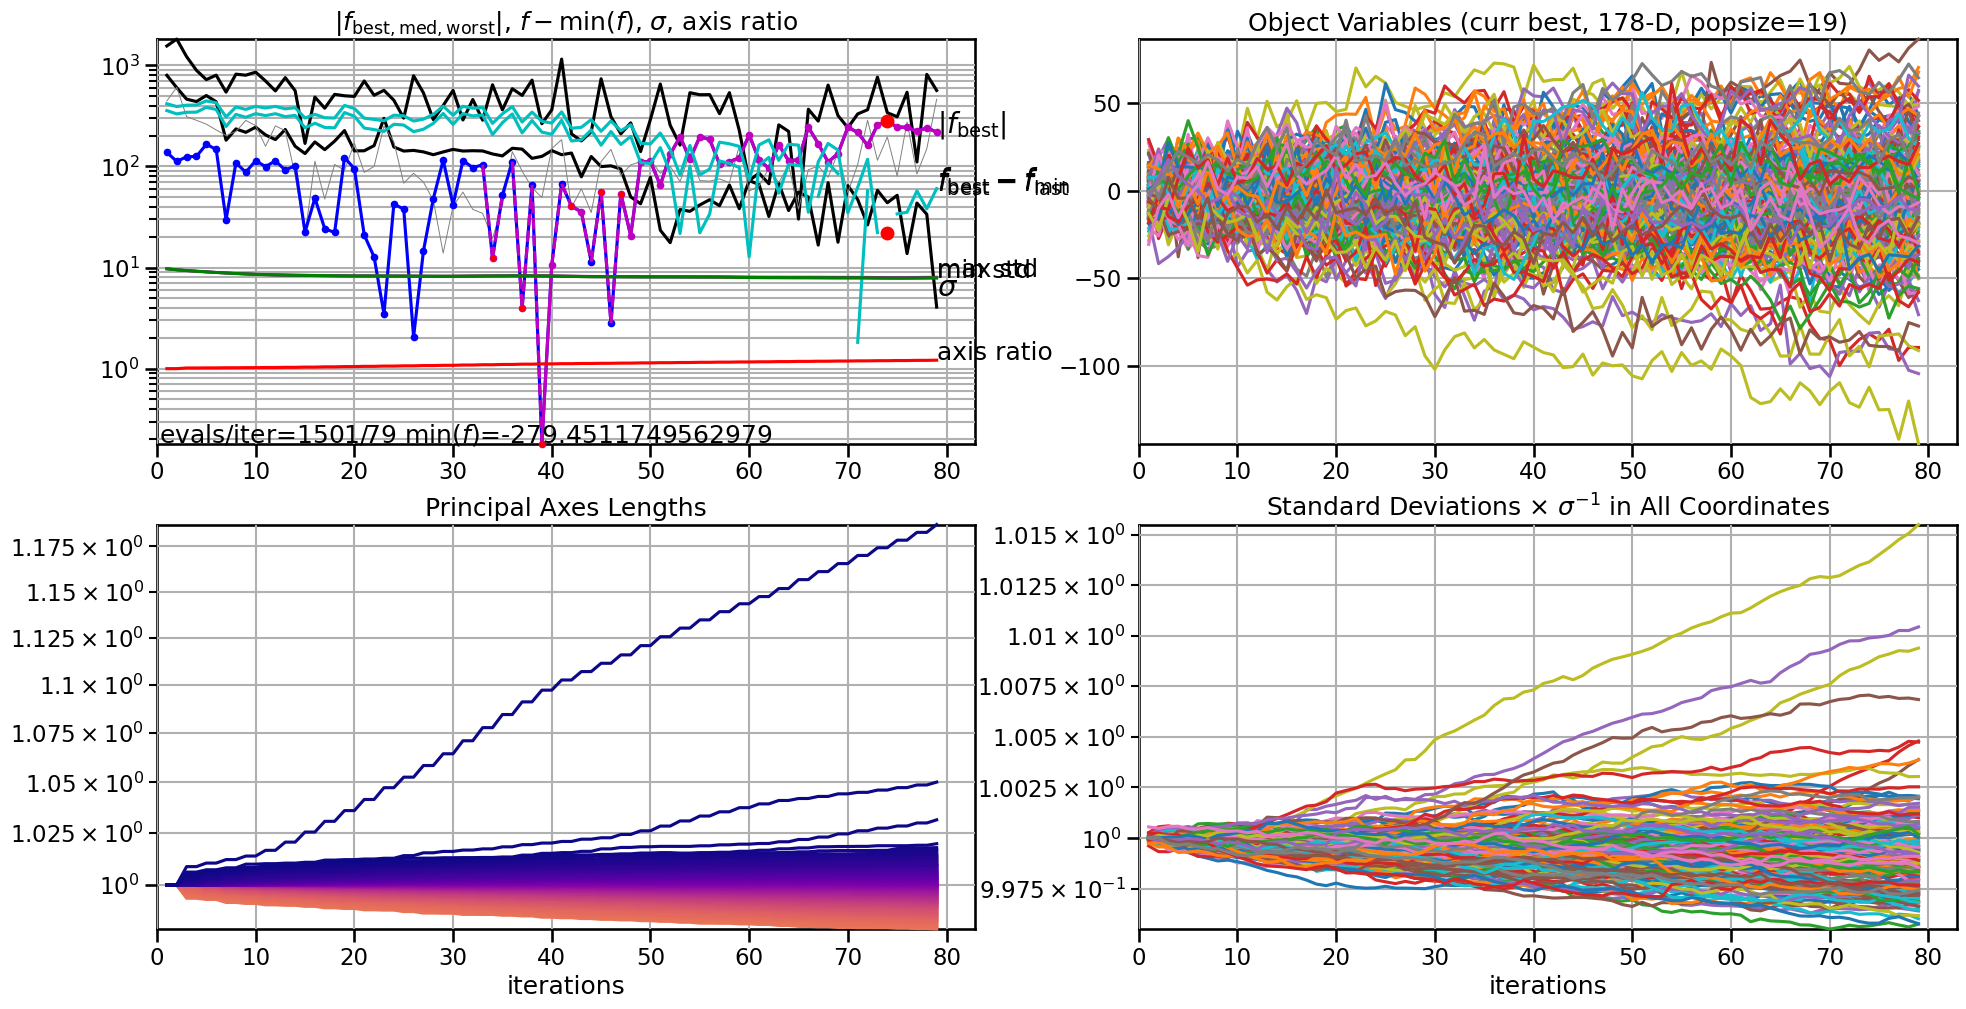

In [178]:
sns.set_context("talk")
plt.rcParams["figure.figsize"] = 20, 10

cma.plot();  # shortcut for es.logger.plot()

Test the final policy

In [179]:
VIDEO_PREFIX_EX6_CMAES_LUNARLANDER_TRAINED = "lab7_ex6_cmaes_lunarlander_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX6_CMAES_LUNARLANDER_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX6_CMAES_LUNARLANDER_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=nn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=500)

env.close()

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);


Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab7/lab7_ex6_cmaes_lunarland…